In [12]:
# =============================================
# Racist Speech Detection in Tweets
# Advanced Text Classification with RNN, LSTM, and Word2Vec
# =============================================

# Import Libraries
import pandas as pd
import numpy as np
import re
import string
import contractions
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE

from sklearn.utils import class_weight

# TensorFlow/Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Gensim for Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import time

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to /home/samyog/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/samyog/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
# =============================================
# 1. Data Loading and Preprocessing
# =============================================

def clean_text(text):
    """Clean raw text by removing URLs, mentions, hashtags, etc."""
    text = text.lower()
    text = contractions.fix(text)  # Expand contractions (e.g., "don't" -> "do not")
    text = re.sub(r"http\S+|www\S+", "", text)           # Remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)                # Remove mentions/hashtags
    text = re.sub(r"\d+", "", text)                      # Remove numbers
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    text = text.encode('ascii', 'ignore').decode('ascii')  # Remove non-ASCII
    text = re.sub(r"\s+", " ", text).strip()             # Remove extra spaces
    return text

def preprocess(text):
    """Apply lemmatization and stopword removal."""
    text = clean_text(text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

# Load datasets
train_path = "/media/samyog/My Folder/AI and ML/Others/Training_2/train_racisit.csv"
test_path = "/media/samyog/My Folder/AI and ML/Others/Training_2/test_racisit.csv"

train_df = pd.read_csv(train_path)  # Columns: 'tweet', 'label'
test_df = pd.read_csv(test_path)    # Columns: 'tweet'

# Dataset Overview
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("\nMissing values in train data:\n", train_df.isnull().sum())
print("\nMissing values in test data:\n", test_df.isnull().sum())

# Preprocess text
train_df['cleaned_tweet'] = train_df['tweet'].apply(preprocess)
test_df['cleaned_tweet'] = test_df['tweet'].apply(preprocess)

print("\nSample cleaned tweet:", train_df['cleaned_tweet'].iloc[0])

Train Data Shape: (31962, 3)
Test Data Shape: (17197, 2)

Missing values in train data:
 id       0
label    0
tweet    0
dtype: int64

Missing values in test data:
 id       0
tweet    0
dtype: int64

Sample cleaned tweet: father dysfunctional selfish drag kid dysfunction


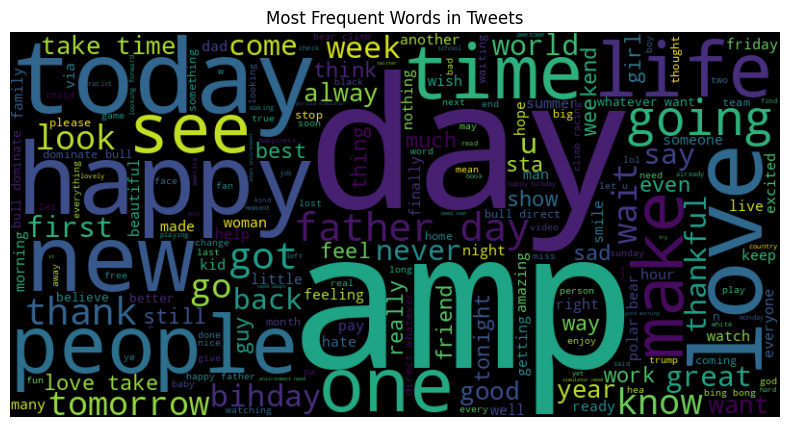


Label Distribution:
 label
0    29720
1     2242
Name: count, dtype: int64


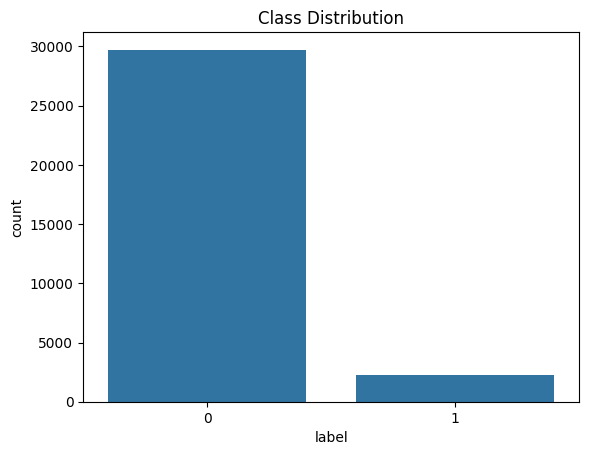

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [ ]:
# =============================================
# 2. Exploratory Data Analysis (EDA)
# =============================================

# Word Cloud
all_words = ' '.join(train_df['cleaned_tweet'])
wordcloud = WordCloud(width=800, height=400).generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Tweets")
plt.show()

# Label Distribution
if 'label' in train_df:
    print("\nLabel Distribution:\n", train_df['label'].value_counts())
    sns.countplot(x=train_df['label'])
    plt.title("Class Distribution")
    plt.show()
    

In [6]:
# =============================================
# 3. Tokenization and Padding
# =============================================

X = train_df['cleaned_tweet']
y = train_df['label']

# Split into train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"\nVocabulary size: {vocab_size}")

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_tweet'])

# Sequence length stats
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))
print(f"Sequence length stats: min={min(seq_lengths)}, max={max(seq_lengths)}, 95th percentile={max_len}")

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


Vocabulary size: 18141
Sequence length stats: min=0, max=19, 95th percentile=11


In [7]:
# Class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("\nClass Weights:", class_weights_dict)


Class Weights: {0: 0.5375478282807047, 1: 7.158174692049272}


In [13]:
# =============================================
# 4. Model 1: Simple RNN
# =============================================

model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.5),  # Regularization
    Dense(1, activation='sigmoid')
])

model_rnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start timing
start_time = time.time()

history_rnn = model_rnn.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)

# End timing and print duration
end_time = time.time()
duration = end_time - start_time
print(f"\n Training Time for Simple RNN: {duration:.2f} seconds ({duration/60:.2f} minutes)")


Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.7165 - loss: 0.5639 - val_accuracy: 0.9040 - val_loss: 0.2524
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.9358 - loss: 0.1839 - val_accuracy: 0.9066 - val_loss: 0.2509
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.9697 - loss: 0.0907 - val_accuracy: 0.9129 - val_loss: 0.2416
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.9803 - loss: 0.0615 - val_accuracy: 0.8824 - val_loss: 0.3432
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.9812 - loss: 0.0568 - val_accuracy: 0.8272 - val_loss: 0.4443
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.9822 - loss: 0.0477 - val_accuracy: 0.9132 - val_loss: 0.2541

 Training Time for Simple RNN: 142.15 seconds (2.37 minutes)


In [14]:
# =============================================
# 5. Model 2: Bidirectional LSTM
# =============================================

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),  # Bidirectional for context
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Start timing
start_time = time.time()

history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)

# End timing and print duration
end_time = time.time()
duration = end_time - start_time
print(f"\n Training Time for Bidirectional LSTM: {duration:.2f} seconds ({duration/60:.2f} minutes)")


Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.7956 - loss: 0.5495 - val_accuracy: 0.8713 - val_loss: 0.3587
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.9187 - loss: 0.2324 - val_accuracy: 0.9287 - val_loss: 0.2267
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.9679 - loss: 0.1134 - val_accuracy: 0.8700 - val_loss: 0.3713
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.9734 - loss: 0.0837 - val_accuracy: 0.9241 - val_loss: 0.2602
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.9806 - loss: 0.0533 - val_accuracy: 0.9000 - val_loss: 0.3839

 Training Time for Bidirectional LSTM: 139.70 seconds (2.33 minutes)


In [15]:

# =============================================
# 6. Model 3: LSTM with Pretrained Word2Vec
# =============================================

# Load pretrained Word2Vec embeddings
word2vec_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional embeddings
embedding_dim = 100

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
    else:
        embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)  # Random for OOV

model_w2v = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False  # Freeze embeddings
    ),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_w2v.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Timing the model training
start_time = time.time()

history_w2v = model_w2v.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")


Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7399 - loss: 0.5525 - val_accuracy: 0.8520 - val_loss: 0.3901
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8140 - loss: 0.4303 - val_accuracy: 0.7823 - val_loss: 0.4935
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8386 - loss: 0.3727 - val_accuracy: 0.8331 - val_loss: 0.3775
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8537 - loss: 0.3292 - val_accuracy: 0.8336 - val_loss: 0.3524
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8677 - loss: 0.2819 - val_accuracy: 0.8344 - val_loss: 0.3819
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8908 - loss: 0.2463 - val_accuracy: 0.8961 - val_loss: 0.2698
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9166 - loss: 0.2016 - val_accuracy: 0.8642 - val_loss: 0.3227
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9245 - loss: 0.1682 - val_accura


                          SIMPLE RNN MODEL PERFORMANCE                          


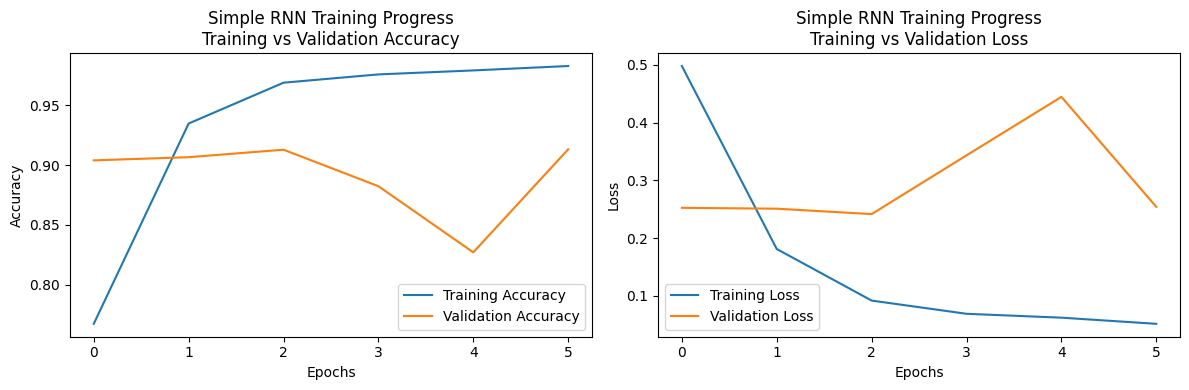

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
════════════════════════════════════════════════════════════
EVALUATION REPORT: SEQUENTIAL_3
════════════════════════════════════════════════════════════

Overall Accuracy: 91.29%

Confusion Matrix:
[[5569  368]
 [ 189  267]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9672    0.9380    0.9524      5937
           1     0.4205    0.5855    0.4895       456

    accuracy                         0.9129      6393
   macro avg     0.6938    0.7618    0.7209      6393
weighted avg     0.9282    0.9129    0.9194      6393

════════════════════════════════════════════════════════════


                      BIDIRECTIONAL LSTM MODEL PERFORMANCE                      


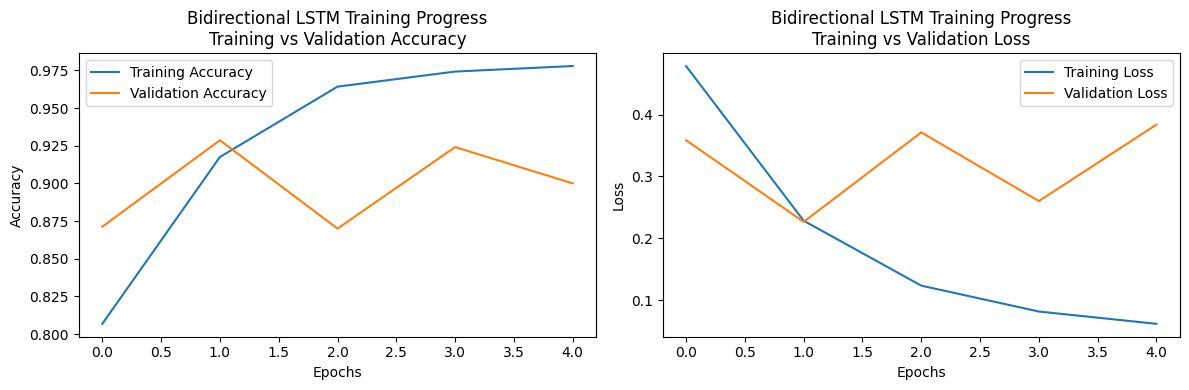

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
════════════════════════════════════════════════════════════
EVALUATION REPORT: SEQUENTIAL_4
════════════════════════════════════════════════════════════

Overall Accuracy: 92.87%

Confusion Matrix:
[[5638  299]
 [ 157  299]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9729    0.9496    0.9611      5937
           1     0.5000    0.6557    0.5674       456

    accuracy                         0.9287      6393
   macro avg     0.7365    0.8027    0.7642      6393
weighted avg     0.9392    0.9287    0.9330      6393

════════════════════════════════════════════════════════════


                        WORD2VEC LSTM MODEL PERFORMANCE                         


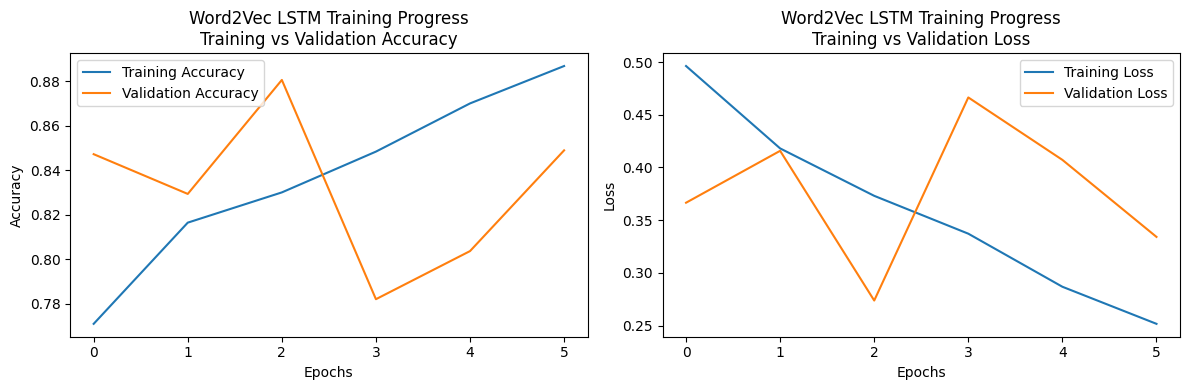

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
════════════════════════════════════════════════════════════
EVALUATION REPORT: SEQUENTIAL_6
════════════════════════════════════════════════════════════

Overall Accuracy: 88.05%

Confusion Matrix:
[[5308  629]
 [ 135  321]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9752    0.8941    0.9329      5937
           1     0.3379    0.7039    0.4566       456

    accuracy                         0.8805      6393
   macro avg     0.6565    0.7990    0.6947      6393
weighted avg     0.9297    0.8805    0.8989      6393

════════════════════════════════════════════════════════════



In [17]:
# =============================================
# 7. Enhanced Model Evaluation with Visualization
# =============================================

from sklearn.metrics import accuracy_score

def plot_training_performance(history, model_name):
    """Visualize model training/validation metrics over epochs."""
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name}\nTraining vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name}\nTraining vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_classification_performance(model, X_test, y_test):
    """Comprehensive evaluation of model performance with metrics."""
    y_pred = model.predict(X_test).round()
    acc = accuracy_score(y_test, y_pred)

    print("═"*60)
    print(f"EVALUATION REPORT: {model.name.upper()}")
    print("═"*60)
    print(f"\nOverall Accuracy: {acc * 100:.2f}%")  # Changed to percentage

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("═"*60 + "\n")

# Visualize and evaluate each model
print("\n" + "="*80)
print("SIMPLE RNN MODEL PERFORMANCE".center(80))
print("="*80)
plot_training_performance(history_rnn, "Simple RNN Training Progress")
evaluate_classification_performance(model_rnn, X_val_pad, y_val)

print("\n" + "="*80)
print("BIDIRECTIONAL LSTM MODEL PERFORMANCE".center(80))
print("="*80)
plot_training_performance(history_lstm, "Bidirectional LSTM Training Progress")
evaluate_classification_performance(model_lstm, X_val_pad, y_val)

print("\n" + "="*80)
print("WORD2VEC LSTM MODEL PERFORMANCE".center(80))
print("="*80)
plot_training_performance(history_w2v, "Word2Vec LSTM Training Progress")
evaluate_classification_performance(model_w2v, X_val_pad, y_val)

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


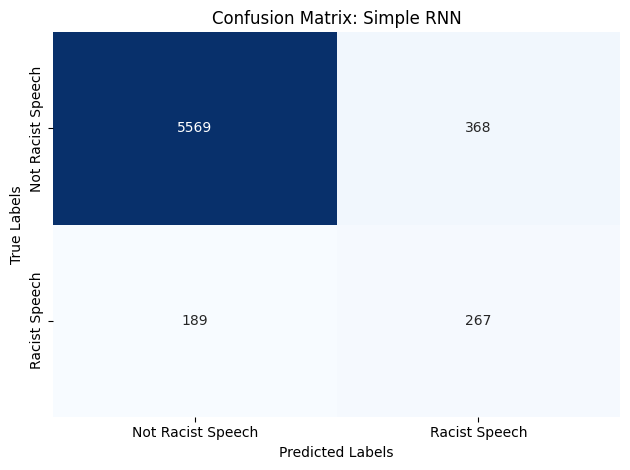

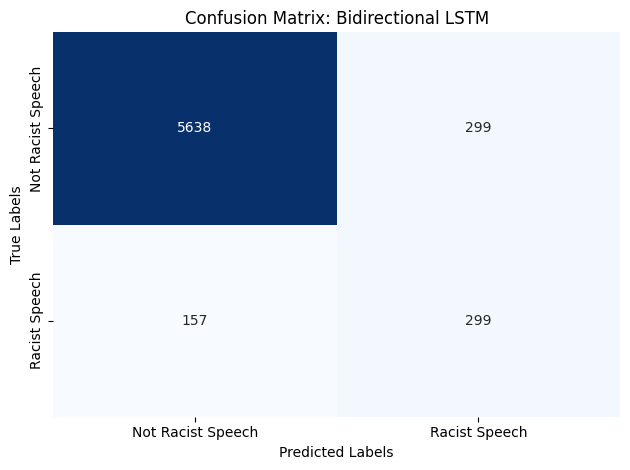

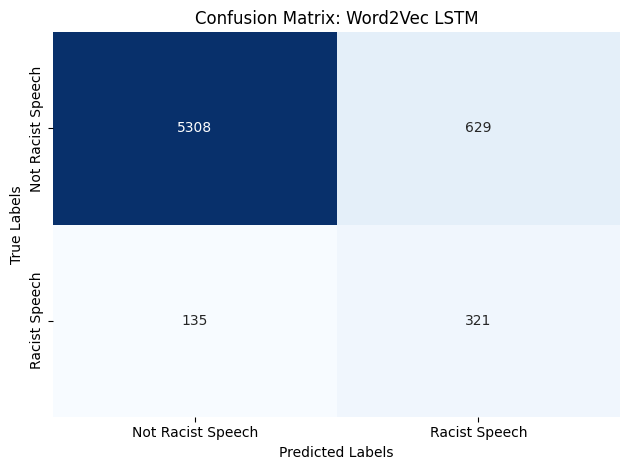

In [18]:
# Create a confusion matrix for all models
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Racist Speech', 'Racist Speech'],
                yticklabels=['Not Racist Speech', 'Racist Speech'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix for each model
y_pred_rnn = model_rnn.predict(X_val_pad).round()
y_pred_lstm = model_lstm.predict(X_val_pad).round()
y_pred_w2v = model_w2v.predict(X_val_pad).round()
plot_confusion_matrix(y_val, y_pred_rnn, "Simple RNN")
plot_confusion_matrix(y_val, y_pred_lstm, "Bidirectional LSTM")
plot_confusion_matrix(y_val, y_pred_w2v, "Word2Vec LSTM")


In [20]:
# ROC Curve function

from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


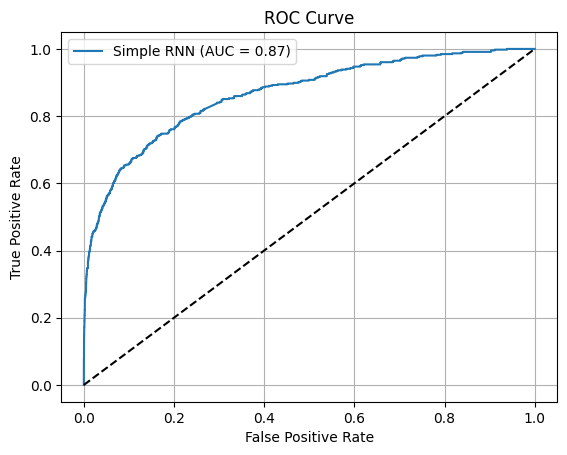

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


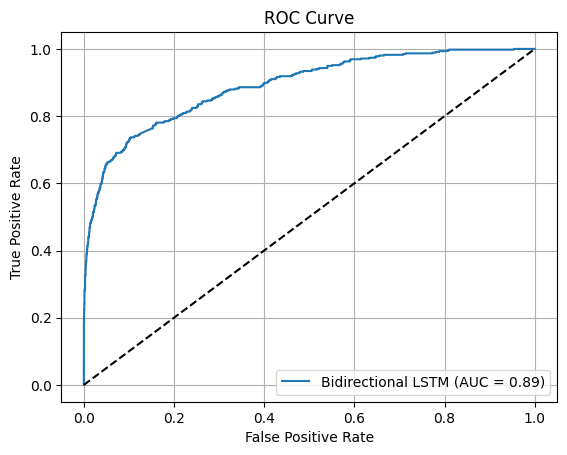

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


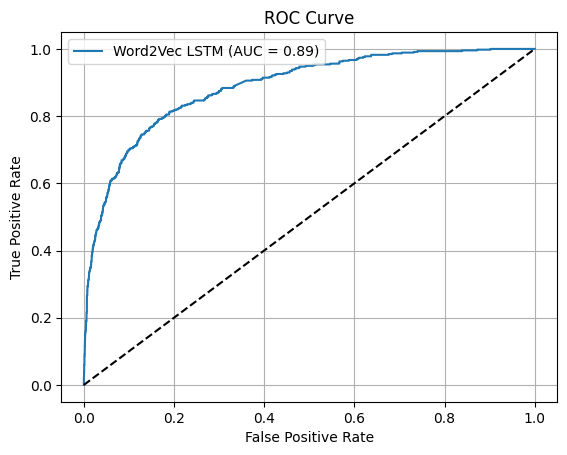

In [21]:
plot_roc(y_val, model_rnn.predict(X_val_pad), "Simple RNN")
plot_roc(y_val, model_lstm.predict(X_val_pad), "Bidirectional LSTM")
plot_roc(y_val, model_w2v.predict(X_val_pad), "Word2Vec LSTM")

In [ ]:
# =============================================
# 9. Real-Time Prediction GUI (Gradio)
# =============================================

import gradio as gr


def predict_racist_speech(text):
    """Predict racist speech label for input text."""
    text = preprocess(text)
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_rnn.predict(padded).round()[0][0]
    return "Racist Speech" if pred == 1 else "Not Racist Speech"

# Launch GUI
gr.Interface(
    fn=predict_racist_speech,
    inputs=gr.Textbox(label="Enter Tweet"),
    outputs=gr.Label(label="Prediction"),
    title="Racist Speech Detector",
    description="Classify tweets as Racist Speech or Not using Bidirectional LSTM"
).launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Created dataset file at: .gradio/flagged/dataset1.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


In [24]:
# =============================================
# 10. Save Predictions
# =============================================

test_preds = model_lstm.predict(X_test_pad).round().astype(int)
submission = test_df.copy()
submission['prediction'] = test_preds
submission.to_csv("test_predictions.csv", index=False)
print("Test predictions saved to 'test_predictions.csv'")

538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test predictions saved to 'test_predictions.csv'
